In [4]:
from emnist_prediction.utils.constants import INPUT_DATA_DIR, DATA_DIR, SUBMISSIONS_DIR
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import pytorch_lightning as pl
import os 
from emnist_prediction.eval.summary import print_summary, plot_distributions, plot_f1_vs_class_prob
from emnist_prediction.utils.utils import id_2_label, label_2_id, oneh_2_label, label_2_1hot, get_classes_count, plot_letters
from emnist_prediction.utils.constants import IMG_SIZE, CLASS_LABELS

for dirname, _, filenames in os.walk(INPUT_DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

c:\users\julia\pycharmprojects\emnist prediction\data\input_data\sample_submission.csv
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\X_test.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\X_train.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\X_val.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\y_train.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\y_val.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\subdata\X_subtest.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\subdata\X_subval.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\subdata\y_subtest.npy
c:\users\julia\pycharmprojects\emnist prediction\data\input_data\subdata\y_subval.npy


### Analiza problemu & zbioru danych

In [5]:
X_train_npy = np.load(INPUT_DATA_DIR / 'X_train.npy')
y_train_npy = np.load(INPUT_DATA_DIR / 'y_train.npy')

X_val_npy = np.load(INPUT_DATA_DIR / 'X_val.npy')
y_val_npy = np.load(INPUT_DATA_DIR / 'y_val.npy')

val_labels = y_val_npy.argmax(axis=-1)

In [6]:
print(X_train_npy.shape)
print(y_train_npy.shape)

print(X_val_npy.shape)
print(y_val_npy.shape)

(151166, 28, 28)
(151166, 26)
(37792, 28, 28)
(37792, 26)


In [7]:
y_train = np.load(INPUT_DATA_DIR / 'y_train.npy')
train_class_count = get_classes_count(y_train)
train_class_prob = train_class_count / train_class_count.sum()
train_class_prob

O    0.132212
S    0.109886
U    0.066688
I    0.063222
C    0.053418
T    0.051969
F    0.048589
M    0.047636
P    0.044177
N    0.043594
A    0.033910
L    0.026865
R    0.026845
E    0.026110
Y    0.025098
W    0.024847
V    0.024543
D    0.024146
B    0.020520
J    0.019912
H    0.016684
X    0.014666
Z    0.014296
Q    0.013786
G    0.013323
K    0.013058
dtype: float64

Przykładowe litery

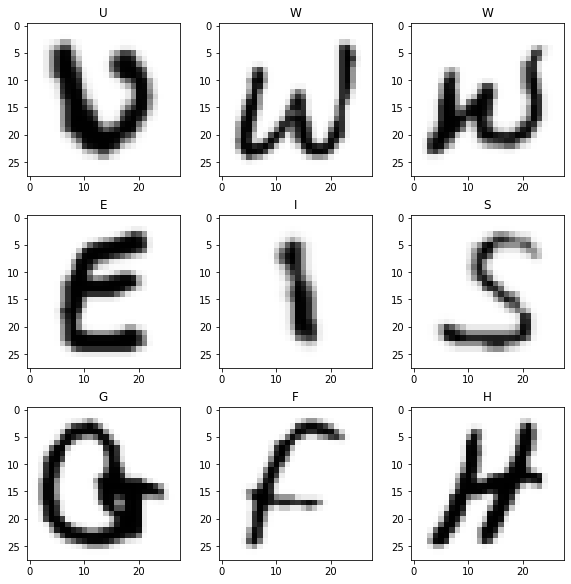

In [8]:
plot_letters(X_train_npy[:9], y_train_npy[:9])

#### Rozkład klas

In [9]:
train_class_count = get_classes_count(y_train_npy)
val_class_count = get_classes_count(y_val_npy)

classes_count = pd.DataFrame({'train': train_class_count, 'val': val_class_count})
classes_count.head()

train   val
O  19986  4997
S  16611  4153
U  10081  2521
I   9557  2389
C   8075  2019

Obserwacje: zbiory treningowy i walidacyjny mają prawie taki sam rozkład, lecz jest on nierównomierny (tak jak wspomniano w opisie problemu)

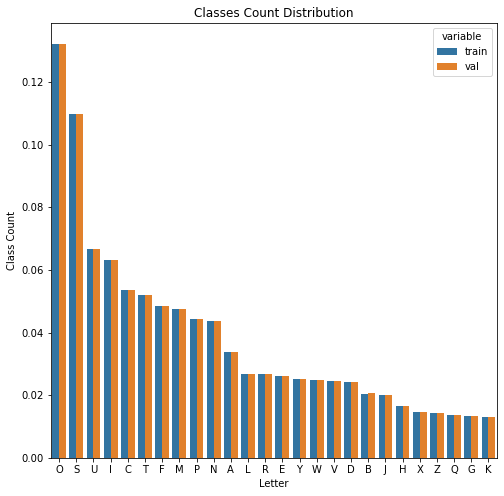

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns 

classes_distribution = classes_count / classes_count.sum()
sorted_class_labels = classes_count.index.sort_values()

plt.figure(figsize=(8, 8))
sns.barplot(data=classes_distribution.reset_index().melt(value_vars=['train', 'val'], id_vars=['index']), y='value',
           x='index', hue='variable') #, order=sorted_class_labels
plt.ylabel('Class Count')
plt.xlabel('Letter')
_ = plt.title('Classes Count Distribution')

##### Jak zdefiniować klasę mniejszościową?

Problematyczne wydaje się to, że tylko 2 klasy mają 'duże' prawdopodobieństwa, a reszta nawet 2/3 krotnie mniejsze. Jednak nie chcemy traktować wszystkich tych klas jako mniejszościowych, więc wybrana została pewna wartość marginesowa, poniżej której klasa jest uznana za mniejszościową

In [11]:
print(f"{classes_distribution['train'].mean():.3f}")
print(f"{classes_distribution['train'].median():.3f}")

0.038
0.026


Wartość równe prawie medianie 

In [12]:
minority_prob_margin = classes_distribution.loc['L', 'train']
print(f"{minority_prob_margin:.3f}")

0.027


#### Rozkład pikseli

In [13]:
print(f"{X_train_npy.mean():.3f}")
print(f"{X_train_npy.std():.3f}")

45.720
85.517


In [14]:
X_mean = X_train_npy.mean()
X_std = X_train_npy.std()

def normalize(X):
    return (X - X_mean) / X_std

Ustandaryzowany rozkład każdego piksela (tj. każdego z 784)

Global mean = -6.116928919834364e-17
Global std = 0.9999999999999994


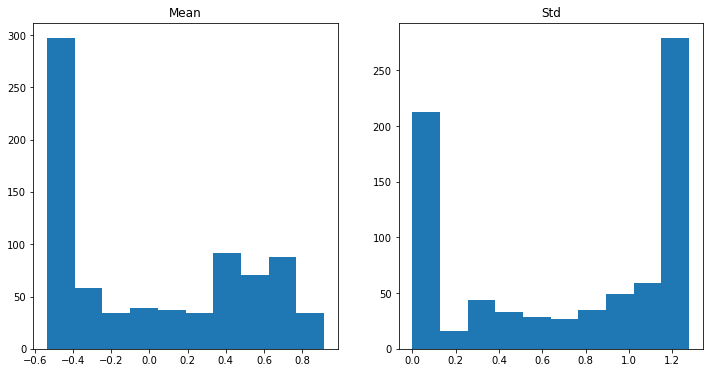

In [15]:
X_normalized = normalize(X_train_npy)

mean_feature = X_normalized.transpose([1, 2, 0]).mean(axis=-1).flatten()
std_feature = X_normalized.transpose([1, 2, 0]).std(axis=-1).flatten()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Mean')
plt.hist(mean_feature)
plt.subplot(122)
plt.title('Std')
plt.hist(std_feature)

print(f"Global mean = {X_normalized.mean()}")
print(f"Global std = {X_normalized.std()}")

#### TSNE
TSNE może być użyte do wizualizacji wielowymiarowych danych w 2D, ale wpierw użyte zostało PCA by zmniejszyć wymiarowość

In [16]:
from sklearn.decomposition import PCA
X = X_train_npy.reshape((len(X_train_npy), -1))
X_std = np.std(X, axis=0)
# To avoid 0 division (even though we could delete it since it does not carry any information) ((It will be removed in PCA))
X_std[X_std == 0] = 1
X = X / X_std 

pca = PCA(n_components=50)
# X_lower_dim = pca.fit_transform(X)

In [17]:
# Read prepared tsne vectors 
X_embedded = np.load(DATA_DIR / 'tsne_train_embed.npy')

In [18]:
X_embedded.shape

(151166, 2)

In [19]:
tsne_embedding = pd.DataFrame({'x': X_embedded[:, 0], 'y': X_embedded[:, 1], 'label': oneh_2_label(y_train_npy)})

In [20]:
tsne_embedding.head()

x          y label
0  -53.247906  12.289304     U
1  -43.392899  55.615932     W
2  -36.068756  68.675423     W
3   14.418263 -25.463440     E
4  111.255104   5.058071     I

Wykres pokazuje, że większość liter tworzy klastry (np. M, N, W), ale zdarzają się też bardziej rozproszone (np. G). 

NIESTETY wykres nie renderuje się na github'ie, więc dostępne jest tylko statyczne zdjęcie "tsne_plot.png"

In [21]:
import plotly.express as px

fig = px.scatter(tsne_embedding, x='x', y='y', color='label')
fig.show()
fig.write_image("tsne_plot.png")

#### Pomocnicze zbiory
Zbiór walidacyjny został podzielony na podzbiór walidacyjny i testowy użyte odpowiednio do walidacji i testowania podczas trenowania

In [22]:
from emnist_prediction.utils.utils import split_save
from emnist_prediction.utils.constants import SUBDATA_DIR

split_save(X_val_npy, y_val_npy, stratify=y_val_npy, writing_dir=SUBDATA_DIR)

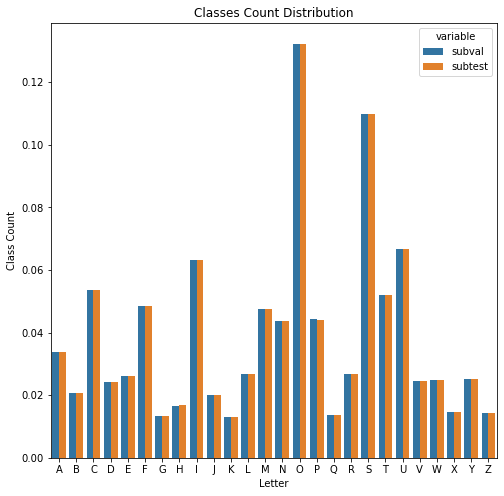

In [23]:
y_subval_npy = np.load(SUBDATA_DIR / 'y_subval.npy')
y_subtest_npy = np.load(SUBDATA_DIR / 'y_subtest.npy')

subval_class_count = get_classes_count(y_subval_npy)
subtest_class_count = get_classes_count(y_subtest_npy)

classes_count = pd.DataFrame({'subval': subval_class_count, 'subtest': subtest_class_count})
classes_distributions = classes_count / classes_count.sum()

sorted_class_labels = classes_count.index.sort_values()

plt.figure(figsize=(8, 8))
sns.barplot(data=classes_distributions.reset_index().melt(value_vars=['subval', 'subtest'], id_vars=['index']), y='value',
           x='index', order=sorted_class_labels, hue='variable')
plt.ylabel('Class Count')
plt.xlabel('Letter')
_ = plt.title('Classes Count Distribution')

In [24]:
subtest_labels = y_subtest_npy.argmax(axis=-1)

#### Transformacje zdjęć

W niektórych przypadkach zdjęcia będą losowo transformowane przy pomocy zdefiniowanej wcześniej transformacji

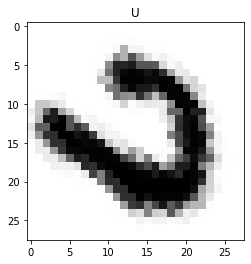

In [25]:
from emnist_prediction.data.transforms import image_transform
from emnist_prediction.utils.utils import visualize_img_transform

visualize_img_transform(X_train_npy[0], y_train_npy[0], image_transform)

### Modele klasyczne
Wzięłam pod uwagę tylko las losowy

In [26]:
RANDOM_FOREST_DIR = DATA_DIR / 'random_forest_experiment'
os.makedirs(RANDOM_FOREST_DIR, exist_ok=True)

In [27]:
import pickle

with open(RANDOM_FOREST_DIR / 'baseline_random_forest_clf', 'rb') as f:
    baseline_rfc = pickle.load(f)

In [28]:
from emnist_prediction.eval.metrics import get_classification_report

rfc_report = get_classification_report(val_labels, baseline_rfc.predict(X_val_npy.reshape(len(X_val_npy), -1)))
rfc_report['train_class_prob'] = train_class_prob
rfc_report.sort_values(by=['f1_score'])

precision    recall  f1_score  support  train_class_prob
D   0.876179  0.814693  0.844318      912          0.024146
H   0.947566  0.803175  0.869416      630          0.016684
Q   0.934641  0.823417  0.875510      521          0.013786
J   0.902439  0.885638  0.893960      752          0.019912
G   0.949115  0.852883  0.898429      503          0.013323
K   0.928726  0.870445  0.898642      494          0.013058
V   0.920582  0.887810  0.903899      927          0.024543
R   0.938606  0.888670  0.912955     1015          0.026845
A   0.885082  0.967994  0.924683     1281          0.033910
N   0.909571  0.940498  0.924776     1647          0.043594
Y   0.928799  0.920969  0.924868      949          0.025098
X   0.959615  0.900722  0.929236      554          0.014666
B   0.956403  0.904639  0.929801      776          0.020520
E   0.960172  0.903749  0.931106      987          0.026110
W   0.967963  0.900958  0.933260      939          0.024847
F   0.931867  0.945563  0.938665     1837          0.048589
Z   0.966862  0.918519  0.942070      540          0.014296
P   0.943195  0.955063  0.949092     1669          0.044177
L   0.958167  0.947783  0.952947     1015          0.026865
U   0.939522  0.967473  0.953293     2521          0.066688
M   0.957529  0.963909  0.960708     1801          0.047636
C   0.952890  0.971768  0.962236     2019          0.053418
I   0.963241  0.965257  0.964248     2389          0.063222
O   0.947227  0.984191  0.965355     4997          0.132212
T   0.966917  0.982179  0.974489     1964          0.051969
S   0.970149  0.986034  0.978027     4153          0.109886

Widać pewną zależność - im mniejsze prawdopodobieństwo klasy, tym mniejsza metryka

<Figure size 720x504 with 0 Axes>

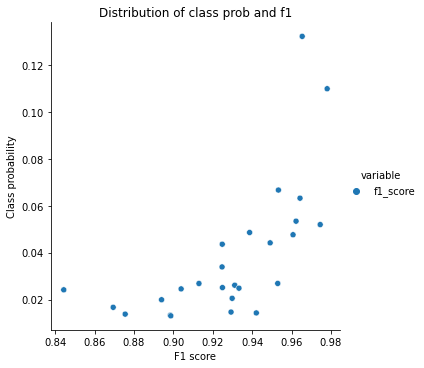

In [29]:
plot_f1_vs_class_prob(rfc_report, 'f1_score')

In [30]:
from emnist_prediction.classical_models.random_forest_utils import get_tree_depths, get_leaves_count

tree_dephts = get_tree_depths(baseline_rfc)
leaves_count = get_leaves_count(baseline_rfc)

print(f"mean tree depth = {np.mean(tree_dephts):.3f}")
print(f"std tree depth = {np.std(tree_dephts):.3f}")
print(f"mean leaves count = {np.mean(leaves_count):.3f}")
print(f"std leaves count = {np.std(leaves_count):.3f}")

mean tree depth = 54.240
std tree depth = 5.779
mean leaves count = 15544.740
std leaves count = 179.972


In [31]:
X_test = np.load(INPUT_DATA_DIR / 'X_test.npy')
test_predictions = baseline_rfc.predict(X_test.reshape(len(X_test), -1))
test_pred_df = pd.DataFrame(test_predictions)
test_pred_df.reset_index().to_csv(SUBMISSIONS_DIR / 'rfc_submission.csv', header=['index', 'class'], index=False)

In [32]:
pd.read_csv(SUBMISSIONS_DIR / 'rfc_submission.csv').shape

(31346, 2)

Przeszukiwanie siatki parametrów zostało użyte by znaleźć możliwie lepsze drzewa

In [33]:
from emnist_prediction.classical_models.random_forest import CustomizedRandomForest

param_grid = [
    {'dimensionality': [400, 100], 'max_depth': [None, 20, 30], 'max_features': ['sqrt', 0.3]}, 
    {'resampler': [RandomUnderSampler(random_state=42), RandomOverSampler(random_state=42), SMOTE()]}, 
    {'class_weight': [None, 'balanced', 'balanced_subsample']}
]

In [34]:
train_labels = y_train_npy.argmax(axis=-1)
val_labels = y_val_npy.argmax(axis=-1)

X_train_flatten = X_train_npy.reshape((len(X_train_npy), -1))
X_val_flatten = X_val_npy.reshape((len(X_val_npy), -1))

In [35]:
with open(RANDOM_FOREST_DIR / 'grid_search_random_forest', 'rb') as f:
    grid_search = pickle.load(f)

In [36]:
cv_results = pd.DataFrame(grid_search.cv_results_)

In [37]:
param_cols = ['param_dimensionality', 'param_max_depth', 'param_max_features',
       'param_resampler', 'param_class_weight']

metric_cols = ['mean_test_avg_weighted_f1', 'mean_train_avg_weighted_f1', 'mean_test_min_f1', 'mean_train_min_f1', 
               'mean_test_total_f1', 'mean_train_total_f1']

In [38]:
cv_results[param_cols]

param_dimensionality param_max_depth param_max_features  \
0                   400            None               sqrt   
1                   400            None                0.3   
2                   400              20               sqrt   
3                   400              20                0.3   
4                   400              30               sqrt   
5                   400              30                0.3   
6                   100            None               sqrt   
7                   100            None                0.3   
8                   100              20               sqrt   
9                   100              20                0.3   
10                  100              30               sqrt   
11                  100              30                0.3   
12                  NaN             NaN                NaN   
13                  NaN             NaN                NaN   
14                  NaN             NaN                NaN   
15                  NaN             NaN                NaN   
16                  NaN             NaN                NaN   
17                  NaN             NaN                NaN   

                        param_resampler  param_class_weight  
0                                   NaN                 NaN  
1                                   NaN                 NaN  
2                                   NaN                 NaN  
3                                   NaN                 NaN  
4                                   NaN                 NaN  
5                                   NaN                 NaN  
6                                   NaN                 NaN  
7                                   NaN                 NaN  
8                                   NaN                 NaN  
9                                   NaN                 NaN  
10                                  NaN                 NaN  
11                                  NaN                 NaN  
12  RandomUnderSampler(random_state=42)                 NaN  
13   RandomOverSampler(random_state=42)                 NaN  
14                              SMOTE()                 NaN  
15                                  NaN                None  
16                                  NaN            balanced  
17                                  NaN  balanced_subsample

In [39]:
cv_results[metric_cols]

mean_test_avg_weighted_f1  mean_train_avg_weighted_f1  mean_test_min_f1  \
0                    0.894106                    0.999987          0.604278   
1                    0.894680                    0.999993          0.614570   
2                    0.893251                    0.999987          0.609854   
3                    0.894267                    0.999993          0.598658   
4                    0.893848                    0.999974          0.611921   
5                    0.894389                    0.999993          0.594086   
6                    0.894201                    0.999990          0.594886   
7                    0.893590                    0.999990          0.607190   
8                    0.893062                    0.999987          0.598658   
9                    0.893996                    0.999983          0.602410   
10                   0.894434                    0.999987          0.609854   
11                   0.894230                    0.999983          0.613546   
12                   0.841670                    0.905175          0.707744   
13                   0.904971                    1.000000          0.721271   
14                   0.907020                    1.000000          0.747784   
15                   0.894038                    0.999990          0.602410   
16                   0.894206                    0.999993          0.615385   
17                   0.894128                    0.999980          0.598658   

    mean_train_min_f1  mean_test_total_f1  mean_train_total_f1  
0            0.999520            0.900206             0.999987  
1            0.999867            0.900728             0.999993  
2            0.999774            0.899319             0.999987  
3            0.999868            0.900441             0.999993  
4            0.999726            0.899830             0.999974  
5            0.999752            0.900617             0.999993  
6            0.999736            0.900367             0.999990  
7            0.999760            0.899776             0.999990  
8            0.999752            0.899177             0.999987  
9            0.999520            0.900137             0.999983  
10           0.999726            0.900546             0.999987  
11           0.999863            0.900217             0.999983  
12           0.851459            0.844479             0.906622  
13           1.000000            0.908629             1.000000  
14           1.000000            0.909417             1.000000  
15           0.999865            0.900161             0.999990  
16           0.999747            0.900250             0.999993  
17           0.999503            0.900232             0.999980

In [40]:
cv_results_subset = cv_results[param_cols + metric_cols]

#### Wniosek

Z poniższej tabeli wynika, że znalezione drzewa mają lepsze wyniki na zbiorze treningowym niż 'podstawowe' drzewo, ale gorsze na walidacyjnym, co jest oznaką przetrenowania.

In [41]:
cv_results_subset

param_dimensionality param_max_depth param_max_features  \
0                   400            None               sqrt   
1                   400            None                0.3   
2                   400              20               sqrt   
3                   400              20                0.3   
4                   400              30               sqrt   
5                   400              30                0.3   
6                   100            None               sqrt   
7                   100            None                0.3   
8                   100              20               sqrt   
9                   100              20                0.3   
10                  100              30               sqrt   
11                  100              30                0.3   
12                  NaN             NaN                NaN   
13                  NaN             NaN                NaN   
14                  NaN             NaN                NaN   
15                  NaN             NaN                NaN   
16                  NaN             NaN                NaN   
17                  NaN             NaN                NaN   

                        param_resampler  param_class_weight  \
0                                   NaN                 NaN   
1                                   NaN                 NaN   
2                                   NaN                 NaN   
3                                   NaN                 NaN   
4                                   NaN                 NaN   
5                                   NaN                 NaN   
6                                   NaN                 NaN   
7                                   NaN                 NaN   
8                                   NaN                 NaN   
9                                   NaN                 NaN   
10                                  NaN                 NaN   
11                                  NaN                 NaN   
12  RandomUnderSampler(random_state=42)                 NaN   
13   RandomOverSampler(random_state=42)                 NaN   
14                              SMOTE()                 NaN   
15                                  NaN                None   
16                                  NaN            balanced   
17                                  NaN  balanced_subsample   

    mean_test_avg_weighted_f1  mean_train_avg_weighted_f1  mean_test_min_f1  \
0                    0.894106                    0.999987          0.604278   
1                    0.894680                    0.999993          0.614570   
2                    0.893251                    0.999987          0.609854   
3                    0.894267                    0.999993          0.598658   
4                    0.893848                    0.999974          0.611921   
5                    0.894389                    0.999993          0.594086   
6                    0.894201                    0.999990          0.594886   
7                    0.893590                    0.999990          0.607190   
8                    0.893062                    0.999987          0.598658   
9                    0.893996                    0.999983          0.602410   
10                   0.894434                    0.999987          0.609854   
11                   0.894230                    0.999983          0.613546   
12                   0.841670                    0.905175          0.707744   
13                   0.904971                    1.000000          0.721271   
14                   0.907020                    1.000000          0.747784   
15                   0.894038                    0.999990          0.602410   
16                   0.894206                    0.999993          0.615385   
17                   0.894128                    0.999980          0.598658   

    mean_train_min_f1  mean_test_total_f1  mean_train_total_f1  
0            0.999520            0.900206             0.999

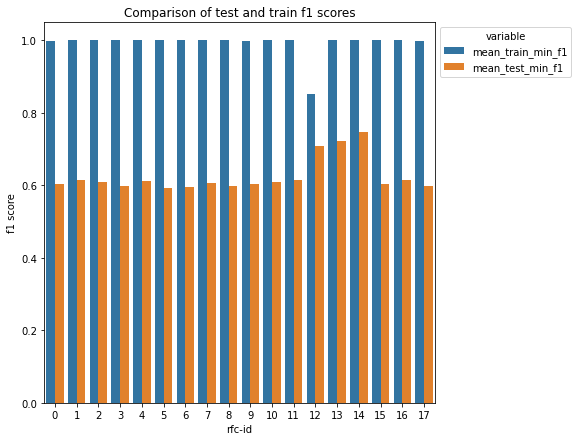

In [42]:
plt.figure(figsize=(7, 7))
ax = sns.barplot(data=cv_results_subset.reset_index().melt(
    value_vars=['mean_train_min_f1', 'mean_test_min_f1'], id_vars=['index']), y='value',
            x='index', hue='variable')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('f1 score')
plt.xlabel('rfc-id')
_ = plt.title('Comparison of test and train f1 scores')

In [43]:
cv_results_subset['mean_test_min_f1'].max()

0.7477840451248993

### Sieć 'Feed Forward'

FNN będzie działać na spłaszczonych wejściach - 784 cechach.

Uwaga: Modele były trenowane na Kaggle/Google Colab, więc tutaj wczytuje zachowane wagi

In [44]:
from emnist_prediction.data.datasets import HandwritingsBalancedDataset, HandwritingsDataset
from emnist_prediction.data.transforms import image_transform, ImgTransform, Reshape
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader

In [45]:
FNN_MODELS = DATA_DIR / 'fnn_models'
FNN_KAGGLE_MODELS = DATA_DIR / 'fnn_models_kaggle'
os.makedirs(FNN_MODELS, exist_ok=True)

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [47]:
X_mean = X_train_npy.mean()
X_std = X_train_npy.std()

def normalize(X):
    return (X - X_mean) / X_std

In [48]:
from emnist_prediction.fnn.fnn import FNN, FNNReg

Wybór rozmiarów ukrytych był raczej intuicyjny - nie ma sensu startować z siecią z wieloma warstwami, więc 4 warstwy wydały się dobrym pomysłem na start

In [49]:
batch_size = 32
input_size = 784
n_classes=len(CLASS_LABELS)
hidden_sizes = [512, 256, 256, 128]

In [50]:
test_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subtest.npy', SUBDATA_DIR / 'y_subtest.npy',
                                             data_transform=normalize)

test_loader = DataLoader(test_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

#### Model odniesienia

Bez augmentacji czy też wag

In [51]:
fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)
fnn.load_state_dict(torch.load(FNN_KAGGLE_MODELS / 'fnn_4_layers_model', map_location="cpu"))
fnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       320
           1       0.98      0.94      0.96       194
           2       0.96      0.99      0.97       505
           3       0.92      0.84      0.88       228
           4       0.94      0.97      0.95       247
           5       0.98      0.95      0.96       459
           6       0.95      0.97      0.96       126
           7       0.95      0.92      0.94       158
           8       0.97      0.98      0.98       597
           9       0.96      0.94      0.95       188
          10       0.92      0.92      0.92       123
          11       0.97      0.95      0.96       254
          12       0.98      0.98      0.98       450
          13       0.97      0.97      0.97       412
          14       0.96      0.99      0.98      1249
          15       0.96      0.98      0.97       417
          16       0.96      0.95      0.96       130
          17       0.94    

In [52]:
report = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report = report.rename(columns={'f1_score': 'f1_score_baseline'})
report = report.drop(['precision', 'recall'], axis=1)
report.sort_values(by=['f1_score_baseline'])

f1_score_baseline  support
D           0.880734      228
K           0.918699      123
V           0.922414      232
H           0.938907      158
J           0.948787      188
U           0.951004      630
R           0.951456      254
W           0.952586      235
E           0.954092      247
Q           0.957529      130
Z           0.958801      135
B           0.960422      194
G           0.960630      126
L           0.962227      254
F           0.962472      459
X           0.963768      139
Y           0.964657      237
N           0.967273      412
P           0.970203      417
C           0.972710      505
A           0.973312      320
O           0.975861     1249
I           0.977481      597
M           0.978912      450
T           0.981744      491
S           0.991338     1038

In [53]:
report['train_class_prob'] = train_class_prob

#### Jak nierównowaga wpływa na predykcje? 
Z poniższego podsumowania wynika, że predykcje < średniej występowały dla klas zdefiniowanych jako mniejszościowe (na podstawie wcześniej wybranego marginesu) - wydaje się więc sensowne spróbować metod złagodzenia tego problemu

In [54]:
print_summary(report, 'f1_score_baseline', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_baseline] = 0.958
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_baseline  train_class_prob
D              0.881             0.024
E              0.954             0.026
H              0.939             0.017
J              0.949             0.020
K              0.919             0.013
Q              0.958             0.014
R              0.951             0.027
U              0.951             0.067
V              0.922             0.025
W              0.953             0.025
Classes with probability BELOW threshold
    f1_score_baseline  train_class_prob
B              0.960             0.021
D              0.881             0.024
E              0.954             0.026
G              0.961             0.013
H              0.939             0.017
J              0.949             0.020
K              0.919             0.013
Q              0.958             0.014
R              0.951             0.027
V              0.922             0.025


Z tego wykresu jednak widać, że model generalnie bardzo dobrze radzi sobie z predykcją nawet mimo nierównowagi

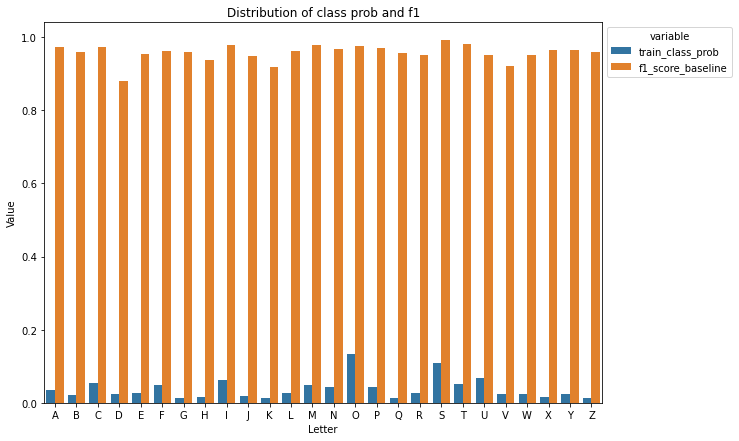

In [55]:
plot_distributions(report, 'f1_score_baseline')

<Figure size 720x504 with 0 Axes>

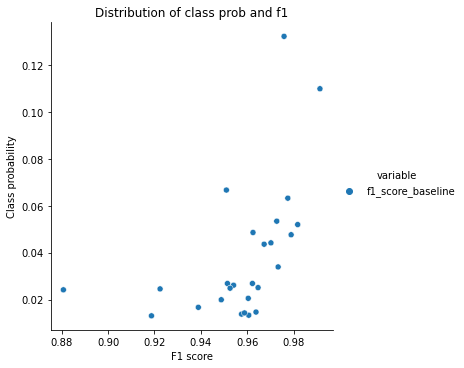

In [56]:
plot_f1_vs_class_prob(report, 'f1_score_baseline')

### Model z ważeniem 

Waga klasy jest odwrotnie ~ do występowania klasy 

In [57]:
from emnist_prediction.data.transforms import get_classes_weights

class_weights = get_classes_weights()

In [58]:
class_weights

tensor([0.2949, 0.4873, 0.1872, 0.4142, 0.3830, 0.2058, 0.7506, 0.5994, 0.1582,
        0.5022, 0.7658, 0.3722, 0.2099, 0.2294, 0.0756, 0.2264, 0.7254, 0.3725,
        0.0910, 0.1924, 0.1500, 0.4075, 0.4025, 0.6818, 0.3984, 0.6995])

In [59]:
fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)
fnn.load_state_dict(torch.load(FNN_KAGGLE_MODELS / 'fnn_weighted_4_layers_model', map_location="cpu"))
fnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       320
           1       0.92      0.94      0.93       194
           2       0.94      0.98      0.96       505
           3       0.91      0.79      0.85       228
           4       0.98      0.92      0.95       247
           5       0.96      0.95      0.96       459
           6       0.92      0.96      0.94       126
           7       0.89      0.94      0.91       158
           8       0.95      0.98      0.97       597
           9       0.97      0.93      0.95       188
          10       0.95      0.87      0.91       123
          11       0.96      0.96      0.96       254
          12       0.98      0.98      0.98       450
          13       0.97      0.94      0.95       412
          14       0.97      0.97      0.97      1249
          15       0.94      0.97      0.95       417
          16       0.98      0.91      0.94       130
          17       0.94    

In [60]:
clf_report_class_weights = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_weighted'] = clf_report_class_weights['f1_score']

Minimalny wynik jest gorszy

In [61]:
report['f1_score_weighted'].min()

0.8457943925233644

In [62]:
print_summary(report, 'f1_score_weighted', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_weighted] = 0.945
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_weighted  train_class_prob
B              0.931             0.021
D              0.846             0.024
G              0.938             0.013
H              0.914             0.017
K              0.907             0.013
Q              0.940             0.014
V              0.903             0.025
W              0.945             0.025
X              0.943             0.015
Y              0.929             0.025
Classes with probability BELOW threshold
    f1_score_weighted  train_class_prob
B              0.931             0.021
D              0.846             0.024
E              0.952             0.026
G              0.938             0.013
H              0.914             0.017
J              0.946             0.020
K              0.907             0.013
Q              0.940             0.014
R              0.952             0.027
V              0.903             0.025


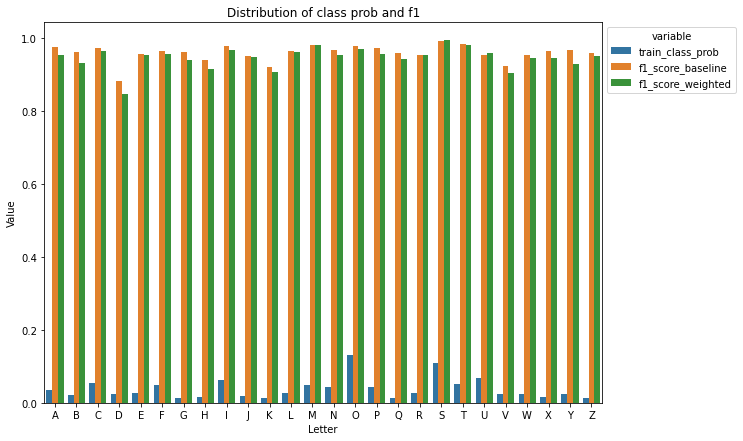

In [63]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_weighted')

<Figure size 720x504 with 0 Axes>

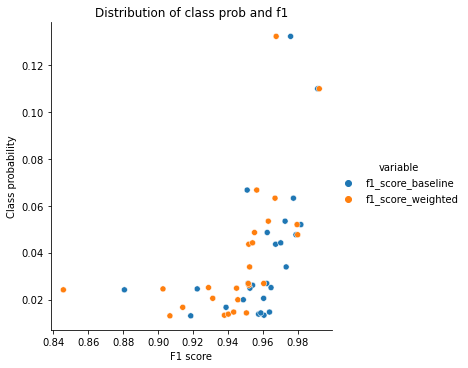

In [64]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted')

Obserwacja: wyniki się pogorszyły

#### Augmentacja danych

In [65]:
# This call is to show how oversampling is used
train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(random_state=42), X_file_path=INPUT_DATA_DIR / 'X_train.npy', y_file_path=INPUT_DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=ImgTransform(image_transform))

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [66]:
hidden_sizes = [512, 256, 256, 128]
fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)
fnn.load_state_dict(torch.load(FNN_KAGGLE_MODELS / 'fnn_4_layers_rand_balanced_model', map_location="cpu"))
fnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       320
           1       0.94      0.96      0.95       194
           2       0.97      0.98      0.97       505
           3       0.85      0.79      0.82       228
           4       0.94      0.95      0.94       247
           5       0.98      0.94      0.96       459
           6       0.86      0.98      0.91       126
           7       0.92      0.96      0.94       158
           8       0.98      0.96      0.97       597
           9       0.85      0.91      0.88       188
          10       0.95      0.94      0.95       123
          11       0.94      0.93      0.94       254
          12       0.96      0.91      0.93       450
          13       0.95      0.92      0.93       412
          14       0.97      0.97      0.97      1249
          15       0.96      0.95      0.96       417
          16       0.84      0.95      0.90       130
          17       0.98    

In [67]:
clf_report_rand_balanced = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_rand_balanced'] = clf_report_rand_balanced['f1_score']

Minimalny wynik nie polepszył się w tym przypadku

In [68]:
report['f1_score_rand_balanced'].min()

0.8227272727272728

In [69]:
print_summary(report, 'f1_score_rand_balanced', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_rand_balanced] = 0.935
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_rand_balanced  train_class_prob
D                   0.823             0.024
G                   0.914             0.013
J                   0.882             0.020
M                   0.934             0.048
N                   0.933             0.044
Q                   0.895             0.014
V                   0.916             0.025
W                   0.885             0.025
Y                   0.917             0.025
Z                   0.873             0.014
Classes with probability BELOW threshold
    f1_score_rand_balanced  train_class_prob
B                   0.949             0.021
D                   0.823             0.024
E                   0.944             0.026
G                   0.914             0.013
H                   0.938             0.017
J                   0.882             0.020
K                   0.947             0.013
Q                

#### Zwiększenie wymiarów modelu

Nie zaszkodzi spróbować jak poradzi sobie trochę większy model

In [70]:
batch_size = 32
input_size = 784
n_classes=len(CLASS_LABELS)
hidden_sizes = [512, 512, 256, 256, 128]

In [71]:
fnn = FNN(input_size=input_size, n_classes=n_classes, hidden_sizes=hidden_sizes)
fnn.load_state_dict(torch.load(FNN_KAGGLE_MODELS / 'fnn_5_layers_model', map_location="cpu"))
fnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       320
           1       0.96      0.92      0.94       194
           2       0.97      0.98      0.98       505
           3       0.87      0.88      0.87       228
           4       0.98      0.94      0.96       247
           5       0.95      0.95      0.95       459
           6       0.94      0.96      0.95       126
           7       0.94      0.94      0.94       158
           8       0.97      0.98      0.97       597
           9       0.95      0.96      0.96       188
          10       0.97      0.90      0.94       123
          11       0.96      0.94      0.95       254
          12       0.97      0.98      0.98       450
          13       0.97      0.94      0.95       412
          14       0.97      0.98      0.97      1249
          15       0.96      0.96      0.96       417
          16       0.90      0.94      0.92       130
          17       0.92    

In [72]:
clf_report_5_layers = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_5_layers'] = clf_report_5_layers['f1_score']

In [73]:
report['f1_score_5_layers'].min()

0.8714596949891067

In [74]:
print_summary(report, 'f1_score_5_layers', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_5_layers] = 0.950
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_5_layers  train_class_prob
B              0.942             0.021
D              0.871             0.024
G              0.949             0.013
H              0.940             0.017
K              0.937             0.013
L              0.948             0.027
Q              0.921             0.014
R              0.940             0.027
V              0.902             0.025
W              0.947             0.025
X              0.946             0.015
Y              0.944             0.025
Classes with probability BELOW threshold
    f1_score_5_layers  train_class_prob
B              0.942             0.021
D              0.871             0.024
E              0.961             0.026
G              0.949             0.013
H              0.940             0.017
J              0.958             0.020
K              0.937             0.013
Q              0.921             0.014


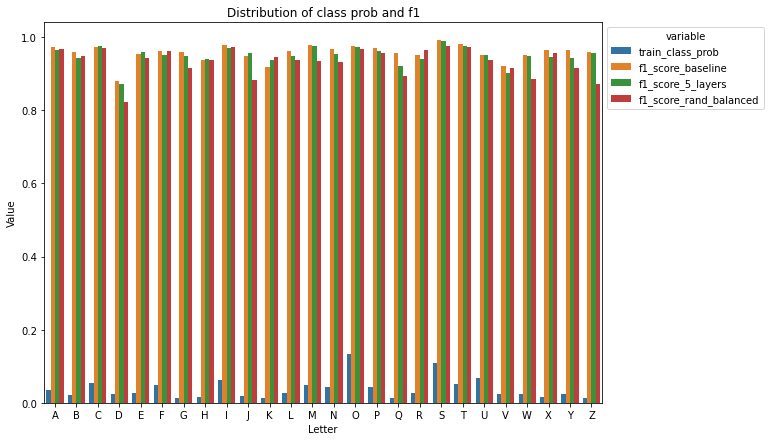

In [75]:
plot_distributions(report, 'f1_score_baseline', 'f1_score_5_layers', 'f1_score_rand_balanced')

<Figure size 720x504 with 0 Axes>

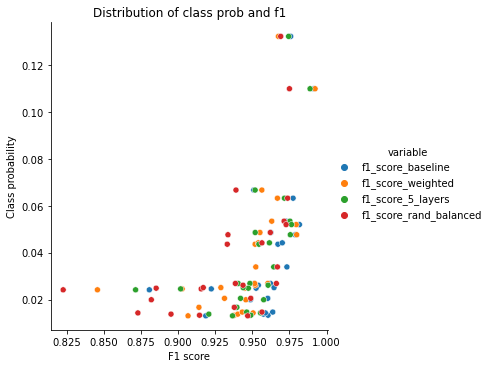

In [76]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers', 'f1_score_rand_balanced')

Text(0.5, 1.0, 'Average f1 score (FNN)')

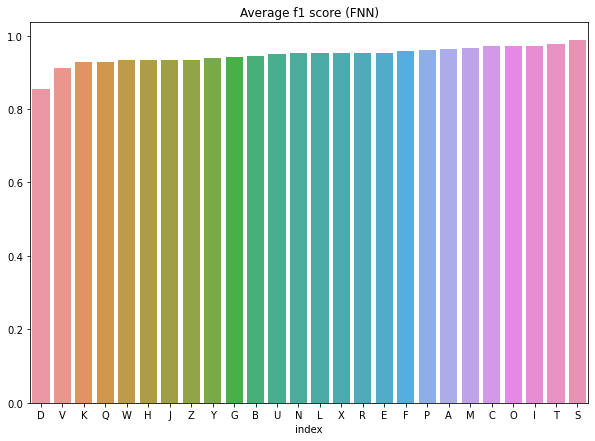

In [77]:
mean_f1_scores = report[['f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers', 'f1_score_rand_balanced']].mean(axis=1)
plt.figure(figsize=(10, 7))
sns.barplot(data=mean_f1_scores.reset_index(), x='index', y=mean_f1_scores.values, 
            order=mean_f1_scores.sort_values().index)
plt.title('Average f1 score (FNN)')

Podsumowanie: model odniesienia osiągnął jak dotąd najlepsze wyniki, a techniki zmniejszenia nierównowagi w tym przypadku nie dały efektu. Modele średnio najgorzej przewidywały literę D i V.

#### Ekstra model

Ten model ma dodatkowe warstwy dropout, a dodatkowo jest trenowany na augmentowanym zbiorze danych

In [78]:
train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(), X_file_path=INPUT_DATA_DIR / 'X_train.npy', y_file_path=INPUT_DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=ImgTransform(image_transform, color_channel=False))

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [79]:
fnn = FNNReg(input_size=input_size, n_classes=n_classes)
fnn.load_state_dict(torch.load(FNN_KAGGLE_MODELS / 'fnn_regularized_model', map_location="cpu"))
fnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(fnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       320
           1       0.92      0.93      0.93       194
           2       0.93      0.97      0.95       505
           3       0.85      0.79      0.82       228
           4       0.94      0.93      0.93       247
           5       0.97      0.91      0.93       459
           6       0.80      0.94      0.87       126
           7       0.82      0.95      0.88       158
           8       0.98      0.91      0.94       597
           9       0.75      0.90      0.82       188
          10       0.90      0.93      0.92       123
          11       0.93      0.91      0.92       254
          12       0.95      0.90      0.92       450
          13       0.92      0.90      0.91       412
          14       0.96      0.97      0.97      1249
          15       0.94      0.94      0.94       417
          16       0.77      0.88      0.82       130
          17       0.92    

In [80]:
clf_report_regularized = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
report['f1_score_regularized'] = clf_report_regularized['f1_score']

Jednak ten model wypadł najgorzej

In [81]:
print_summary(report, 'f1_score_regularized', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_regularized] = 0.909
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_regularized  train_class_prob
D                 0.815             0.024
G                 0.869             0.013
H                 0.882             0.017
J                 0.816             0.020
N                 0.906             0.044
Q                 0.821             0.014
R                 0.899             0.027
V                 0.902             0.025
W                 0.901             0.025
Y                 0.899             0.025
Z                 0.822             0.014
Classes with probability BELOW threshold
    f1_score_regularized  train_class_prob
B                 0.925             0.021
D                 0.815             0.024
E                 0.935             0.026
G                 0.869             0.013
H                 0.882             0.017
J                 0.816             0.020
K                 0.916             0.013
Q              

<Figure size 720x504 with 0 Axes>

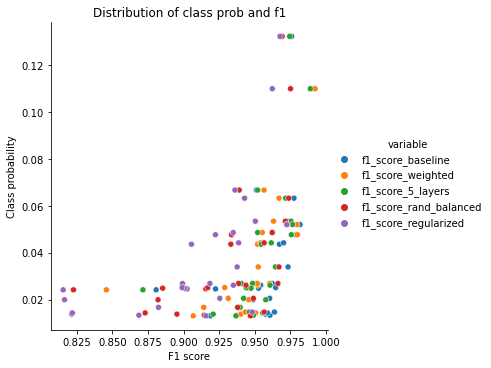

In [82]:
plot_f1_vs_class_prob(report, 'f1_score_baseline', 'f1_score_weighted', 'f1_score_5_layers', 'f1_score_rand_balanced', 'f1_score_regularized')

### Konwolucyjne sieci 


In [83]:
from emnist_prediction.cnn.cnn import DeepCNN
from emnist_prediction.cnn.custom_layers import CustomConv2d, Flatten

In [84]:
CNN_MODELS = DATA_DIR / 'cnn_models'
CNN_KAGGLE_MODELS = DATA_DIR / 'cnn_models_kaggle'

In [85]:
batch_size = 32
n_classes=len(CLASS_LABELS)

reshape_transform = Reshape(shape=(1, *IMG_SIZE))

test_dataset = HandwritingsDataset(SUBDATA_DIR / 'X_subtest.npy', SUBDATA_DIR / 'y_subtest.npy',
                                             data_transform=normalize, sample_transform=reshape_transform)

test_loader = DataLoader(test_dataset, num_workers=4,
                                batch_size=batch_size, shuffle=False)

Pierwszy model to warstwy 3 CNV + Flatten + 3 Linear - wydają się wystarczające na start

In [86]:
import torch.nn as nn 

conv_layers = [CustomConv2d(1, 32, 3, pad=1), CustomConv2d(32, 64, 3, pad=1),
               CustomConv2d(64, 128, 3, pad=1)]

n_conv_output = 28 * 28 * 128

linear_layers = [nn.Linear(n_conv_output, 1024), nn.Linear(1024, 512), nn.Linear(512, n_classes)]

In [87]:
cnn = DeepCNN(conv_layers, linear_layers)
cnn.load_state_dict(torch.load(DATA_DIR / 'cnn_models_google/cnn_model_baseline', map_location="cpu"))
cnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       320
           1       0.99      0.97      0.98       194
           2       0.98      0.98      0.98       505
           3       0.89      0.92      0.90       228
           4       0.98      0.98      0.98       247
           5       0.98      0.99      0.98       459
           6       0.92      1.00      0.96       126
           7       0.97      0.97      0.97       158
           8       0.98      0.99      0.98       597
           9       0.94      0.99      0.97       188
          10       0.97      0.92      0.95       123
          11       0.99      0.94      0.97       254
          12       0.99      0.97      0.98       450
          13       0.96      0.97      0.97       412
          14       0.98      0.98      0.98      1249
          15       0.98      0.99      0.98       417
          16       0.96      0.98      0.97       130
          17       0.97    

In [88]:
cnn_report = get_classification_report(subtest_labels, torch.cat(predictions).numpy())
cnn_report = cnn_report.rename(columns={'f1_score': 'f1_score_baseline'})
cnn_report = cnn_report.drop(['precision', 'recall'], axis=1)

In [89]:
cnn_report['train_class_prob'] = train_class_prob

In [90]:
cnn_report.sort_values(by=['support'])

f1_score_baseline  support  train_class_prob
K           0.945607      123          0.013058
G           0.958175      126          0.013323
Q           0.969466      130          0.013786
Z           0.973978      135          0.014296
X           0.964286      139          0.014666
H           0.968354      158          0.016684
J           0.966234      188          0.019912
B           0.981723      194          0.020520
D           0.904762      228          0.024146
V           0.925110      232          0.024543
W           0.972516      235          0.024847
Y           0.974249      237          0.025098
E           0.979839      247          0.026110
L           0.967742      254          0.026865
R           0.978474      254          0.026845
A           0.985871      320          0.033910
N           0.968599      412          0.043594
P           0.984468      417          0.044177
M           0.983165      450          0.047636
F           0.983713      459          0.048589
T           0.982564      491          0.051969
C           0.983152      505          0.053418
I           0.984153      597          0.063222
U           0.961629      630          0.066688
S           0.995183     1038          0.109886
O           0.981132     1249          0.132212

In [91]:
print_summary(cnn_report, 'f1_score_baseline', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_baseline] = 0.970
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_baseline  train_class_prob
D              0.905             0.024
G              0.958             0.013
H              0.968             0.017
J              0.966             0.020
K              0.946             0.013
L              0.968             0.027
N              0.969             0.044
Q              0.969             0.014
U              0.962             0.067
V              0.925             0.025
X              0.964             0.015
Classes with probability BELOW threshold
    f1_score_baseline  train_class_prob
B              0.982             0.021
D              0.905             0.024
E              0.980             0.026
G              0.958             0.013
H              0.968             0.017
J              0.966             0.020
K              0.946             0.013
Q              0.969             0.014
R              0.978             0.027


In [92]:
cnn_report['f1_score_baseline'].min()

0.9047619047619048

Lepszy wynik niż dla sieci FNN

In [93]:
cnn_report['f1_score_baseline'].min() > report['f1_score_baseline'].min()

True

### CNN ważone
Podobnie jak z FNN dodane zostały wagi

In [94]:
cnn = DeepCNN(conv_layers, linear_layers, class_weights=class_weights)
cnn.load_state_dict(torch.load(CNN_KAGGLE_MODELS / 'cnn_3_conv_3_lin_class_weights_05-11-2023 59_13_09', map_location="cpu"))
cnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       320
           1       0.96      0.97      0.97       194
           2       0.97      0.97      0.97       505
           3       0.88      0.93      0.91       228
           4       0.97      0.98      0.98       247
           5       0.98      0.97      0.98       459
           6       0.96      0.97      0.96       126
           7       0.94      0.97      0.96       158
           8       0.99      0.96      0.97       597
           9       0.92      0.97      0.95       188
          10       0.94      0.98      0.96       123
          11       0.92      0.98      0.95       254
          12       0.98      0.99      0.98       450
          13       0.98      0.97      0.98       412
          14       0.99      0.97      0.98      1249
          15       0.98      0.99      0.99       417
          16       0.97      0.95      0.96       130
          17       0.98    

In [95]:
clf_report_cnn_class_weights = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

In [96]:
cnn_report['f1_score_class_weighted'] = clf_report_cnn_class_weights['f1_score']

Test score: 0.91446

In [97]:
print(f"Min f1 score (imbalanced) = {cnn_report['f1_score_baseline'].min()}")
print(f"Min f1 score with class weights = {cnn_report['f1_score_class_weighted'].min()}")

Min f1 score (imbalanced) = 0.9047619047619048
Min f1 score with class weights = 0.9083155650319831


In [98]:
np.mean(cnn_report['f1_score_class_weighted'] > cnn_report['f1_score_baseline'])

0.38461538461538464

In [99]:
print_summary(cnn_report, 'f1_score_class_weighted', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_class_weighted] = 0.967
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_class_weighted  train_class_prob
B                    0.967             0.021
D                    0.908             0.024
G                    0.964             0.013
H                    0.960             0.017
J                    0.948             0.020
K                    0.956             0.013
L                    0.949             0.027
Q                    0.961             0.014
U                    0.961             0.067
V                    0.931             0.025
W                    0.959             0.025
X                    0.967             0.015
Classes with probability BELOW threshold
    f1_score_class_weighted  train_class_prob
B                    0.967             0.021
D                    0.908             0.024
E                    0.976             0.026
G                    0.964             0.013
H                    0.960             0.0

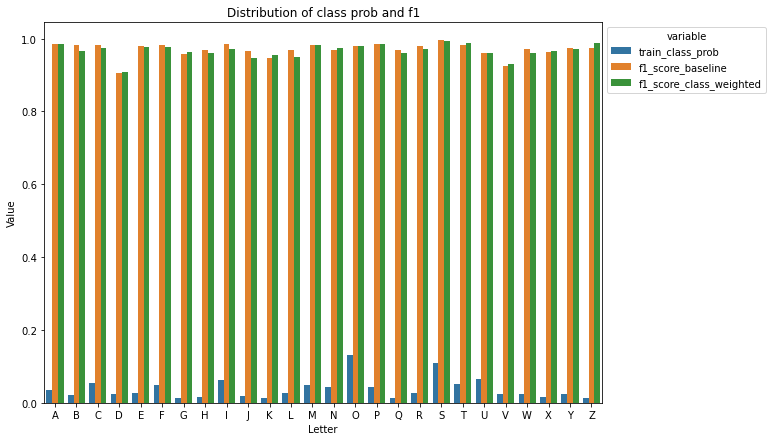

In [100]:
plot_distributions(cnn_report, 'f1_score_baseline', 'f1_score_class_weighted')

<Figure size 720x504 with 0 Axes>

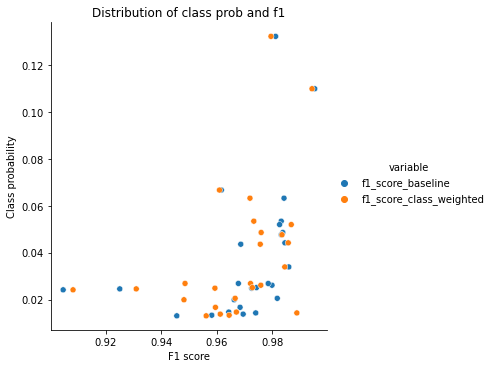

In [101]:
plot_f1_vs_class_prob(cnn_report, 'f1_score_baseline', 'f1_score_class_weighted')

#### Augmentacja
Został uzyty zbiór augmentowany, ale trochę w innym wydaniu - zamiast wyrównywać liczności do klasy najczęstszej, wybrany został kwantyl 0.75, i tylko dla klas poniżej tego kwantyla zwiększane zostały liczności. 

In [102]:
upper_quantile = int(train_class_count.quantile(q=0.75))
print(upper_quantile)
oversample_count = {i: max(upper_quantile, train_class_count[clazz]) for i, clazz in enumerate(CLASS_LABELS) }

7309


In [103]:
from imblearn.over_sampling import RandomOverSampler

image_transform = ImgTransform(image_transform, color_channel=True)
reshape_transform = Reshape(shape=(1, *IMG_SIZE))

train_rand_balanced_dataset = HandwritingsBalancedDataset(RandomOverSampler(sampling_strategy=oversample_count, random_state=42), X_file_path=INPUT_DATA_DIR / 'X_train.npy', y_file_path=INPUT_DATA_DIR / 'y_train.npy',
                                            data_transform=normalize, sample_transform=image_transform)

train_rand_balanced_loader = DataLoader(train_rand_balanced_dataset, num_workers=4,
                         batch_size=batch_size, shuffle=True)

In [104]:
cnn = DeepCNN(conv_layers, linear_layers)
cnn.load_state_dict(torch.load(CNN_KAGGLE_MODELS / 'cnn_3_conv_3_rand_balanced_05-11-2023 03_14_49', map_location="cpu"))
cnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       320
           1       0.97      0.99      0.98       194
           2       0.98      0.97      0.98       505
           3       0.92      0.92      0.92       228
           4       0.99      0.98      0.98       247
           5       0.99      0.97      0.98       459
           6       0.96      0.98      0.97       126
           7       0.97      0.98      0.97       158
           8       0.99      0.97      0.98       597
           9       0.95      0.96      0.95       188
          10       0.94      0.96      0.95       123
          11       0.94      0.97      0.95       254
          12       0.97      0.99      0.98       450
          13       0.98      0.96      0.97       412
          14       0.98      0.98      0.98      1249
          15       0.96      1.00      0.98       417
          16       0.99      0.98      0.98       130
          17       0.97    

In [105]:
clf_report_cnn_rand_balanced = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

Test score: 0.90897 - więc w rzeczywistości trochę gorszy wynik niż dla tutejszego zbioru

In [106]:
clf_report_cnn_rand_balanced['f1_score'].min()

0.9190371991247264

In [107]:
cnn_report['f1_score_rand_balanced'] = clf_report_cnn_rand_balanced['f1_score']

#### Zwiększona sieć konwolucyjna

Do warstw konwolucyjnych można dodawać warstwy 'Pooling', żeby zmniejszyć wymiary zdjęcia, czy też zastosować normalizację dla batch'ów.  

In [108]:
dropout_prob = 0.5

conv_layers = [CustomConv2d(1, 32, 3, pad=1, drop=dropout_prob, batch_norm=True, pooling=2), 
               CustomConv2d(32, 64, 3, pad=1, drop=dropout_prob, batch_norm=True, pooling=2),
               CustomConv2d(64, 128, 3, pad=1, drop=dropout_prob, batch_norm=True, pooling=2)]

n_conv_output = 1152

linear_layers = [nn.Linear(n_conv_output, 512), 
                 nn.Dropout(p=dropout_prob), 
                 nn.Linear(512, 256), 
                 nn.Linear(256, n_classes)]

In [109]:
cnn = DeepCNN(conv_layers, linear_layers)
cnn.load_state_dict(torch.load(CNN_KAGGLE_MODELS / 'deep_cnn_model', map_location="cpu"))
cnn.eval()

trainer = pl.Trainer()
predictions = trainer.predict(cnn, test_loader)

print(classification_report(subtest_labels, torch.cat(predictions).numpy()))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\julia\anaconda3\envs\DataCampTutorials\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting: |          | 0/? [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       320
           1       0.99      0.99      0.99       194
           2       0.99      0.99      0.99       505
           3       0.94      0.91      0.92       228
           4       0.98      0.99      0.98       247
           5       0.98      0.98      0.98       459
           6       0.99      0.99      0.99       126
           7       0.98      0.97      0.97       158
           8       0.99      0.99      0.99       597
           9       0.98      0.96      0.97       188
          10       0.95      0.97      0.96       123
          11       0.98      0.97      0.98       254
          12       0.98      0.99      0.98       450
          13       0.98      0.98      0.98       412
          14       0.98      0.99      0.98      1249
          15       0.99      0.99      0.99       417
          16       1.00      0.97      0.98       130
          17       0.98    

In [110]:
clf_report_cnn_deeper = get_classification_report(subtest_labels, torch.cat(predictions).numpy())

In [111]:
cnn_report['f1_score_deeper'] = clf_report_cnn_deeper['f1_score']

Test score = 0.93385 (najlepszy z wyników)

In [112]:
cnn_report['f1_score_deeper'].min()

0.9223946784922396

In [113]:
print_summary(cnn_report, 'f1_score_deeper', threshold_value=minority_prob_margin)

Mean f1 score [f1_score_deeper] = 0.976
Threshold value = 0.027
Classes with f1 score BELOW mean
    f1_score_deeper  train_class_prob
D            0.924             0.024
H            0.975             0.017
J            0.971             0.020
K            0.960             0.013
N            0.976             0.044
U            0.960             0.067
V            0.922             0.025
W            0.968             0.025
X            0.967             0.015
Classes with probability BELOW threshold
    f1_score_deeper  train_class_prob
B            0.995             0.021
D            0.924             0.024
E            0.984             0.026
G            0.992             0.013
H            0.975             0.017
J            0.971             0.020
K            0.960             0.013
Q            0.984             0.014
R            0.976             0.027
V            0.922             0.025
W            0.968             0.025
X            0.967             0.015
Y        

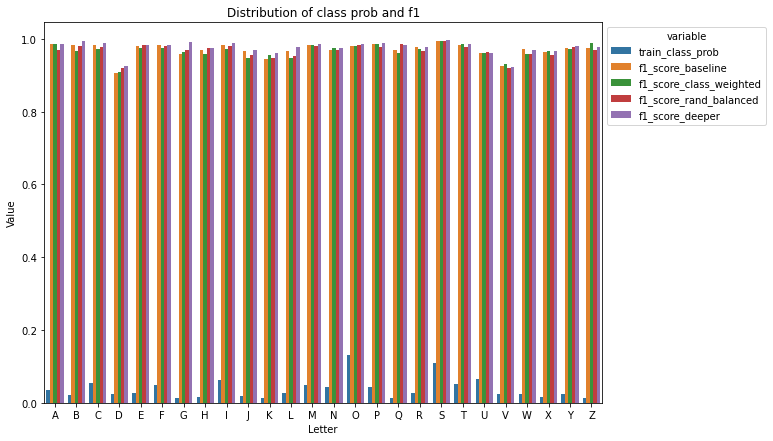

In [114]:
plot_distributions(cnn_report, 'f1_score_baseline', 'f1_score_class_weighted', 'f1_score_rand_balanced', 'f1_score_deeper')

<Figure size 720x504 with 0 Axes>

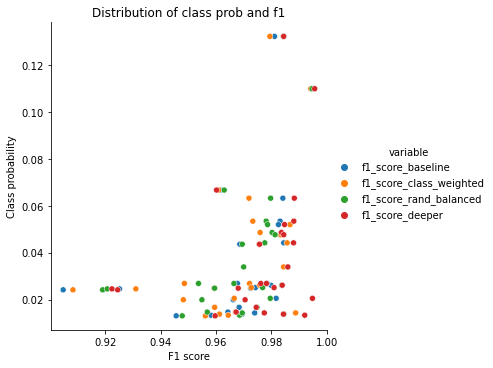

In [115]:
plot_f1_vs_class_prob(cnn_report, 'f1_score_baseline', 'f1_score_class_weighted', 'f1_score_rand_balanced', 'f1_score_deeper')

Podobnie jak dla sieci FNN najgorsze wyniki są dla liter D i V

Text(0.5, 1.0, 'Average f1 score (CNN)')

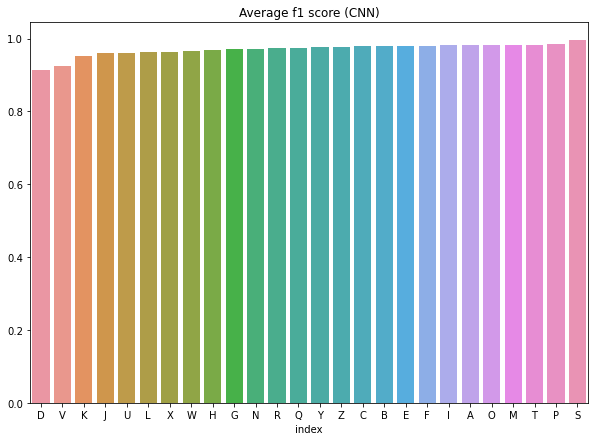

In [116]:
mean_f1_scores = cnn_report[['f1_score_baseline', 'f1_score_class_weighted', 'f1_score_deeper', 'f1_score_rand_balanced']].mean(axis=1)
plt.figure(figsize=(10, 7))
sns.barplot(data=mean_f1_scores.reset_index(), x='index', y=mean_f1_scores.values, 
            order=mean_f1_scores.sort_values().index)
plt.title('Average f1 score (CNN)')

#### Porównanie modeli CNN i FNN i Random Forest

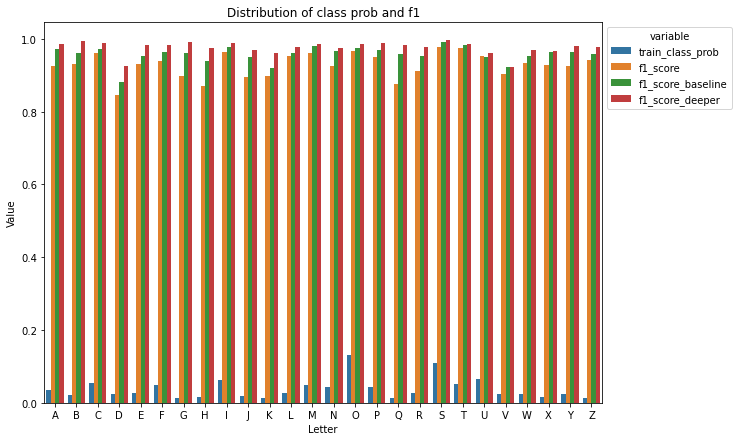

In [123]:
plot_distributions(pd.merge(rfc_report, pd.merge(report, cnn_report, left_index=True, right_index=True, suffixes=(None, '_cnn')), left_index=True, right_index=True, suffixes=('_rf', None)), 
    'f1_score', 'f1_score_baseline', 'f1_score_deeper')

Drzewo losowe uzyskało najniższe wyniki. Prawie dla każdej klasy lepszy wynik był osiągany dla sieci konwolucyjnych.

In [122]:
np.round(np.mean(cnn_report['f1_score_deeper'] > report['f1_score_baseline']), 2)

0.96

Jednak różnica jest dosyć niewielka

In [121]:
np.round(np.mean(cnn_report['f1_score_baseline'] - report['f1_score_baseline']) * 100, 2)

1.25